# Training a force field (Energies of conformers)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymatviz.parity import density_scatter_with_hist
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from rdkit.Chem import PyMol

## Helpers to generate the training data

In [17]:
def gen_conformers(mol, numConfs=10_000, maxAttempts=1000, pruneRmsThresh=0.2, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, enforceChirality=True):
    ids = AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, maxAttempts=maxAttempts, pruneRmsThresh=pruneRmsThresh, useExpTorsionAnglePrefs=useExpTorsionAnglePrefs, useBasicKnowledge=useBasicKnowledge, enforceChirality=enforceChirality, numThreads=0)
    return list(ids)

In [18]:
def calc_energy(mol, conformer_id, iterations=0):
	ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=conformer_id)
	ff.Initialize()
	ff.CalcEnergy()
	results = {}
	if iterations > 0:
		results["converged"] = ff.Minimize(maxIts=iterations)
	results["energy_abs"] = ff.CalcEnergy()
	return results

In [19]:
mol = Chem.AddHs(Chem.MolFromSmiles('CC(CCC)CC(C)(CCCC)O'))

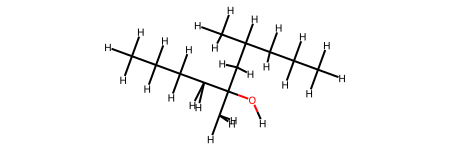

In [20]:
mol

In [21]:
conformer_ids = gen_conformers(mol)

In [30]:
v= PyMol.MolViewer()
v.DeleteAll()
for cid in conformer_ids[:50]: 
    v.ShowMol(mol,confId=cid,name='Conf-%d'%cid,showOnly=False)

In [31]:
v.server.do('set grid_mode, on')

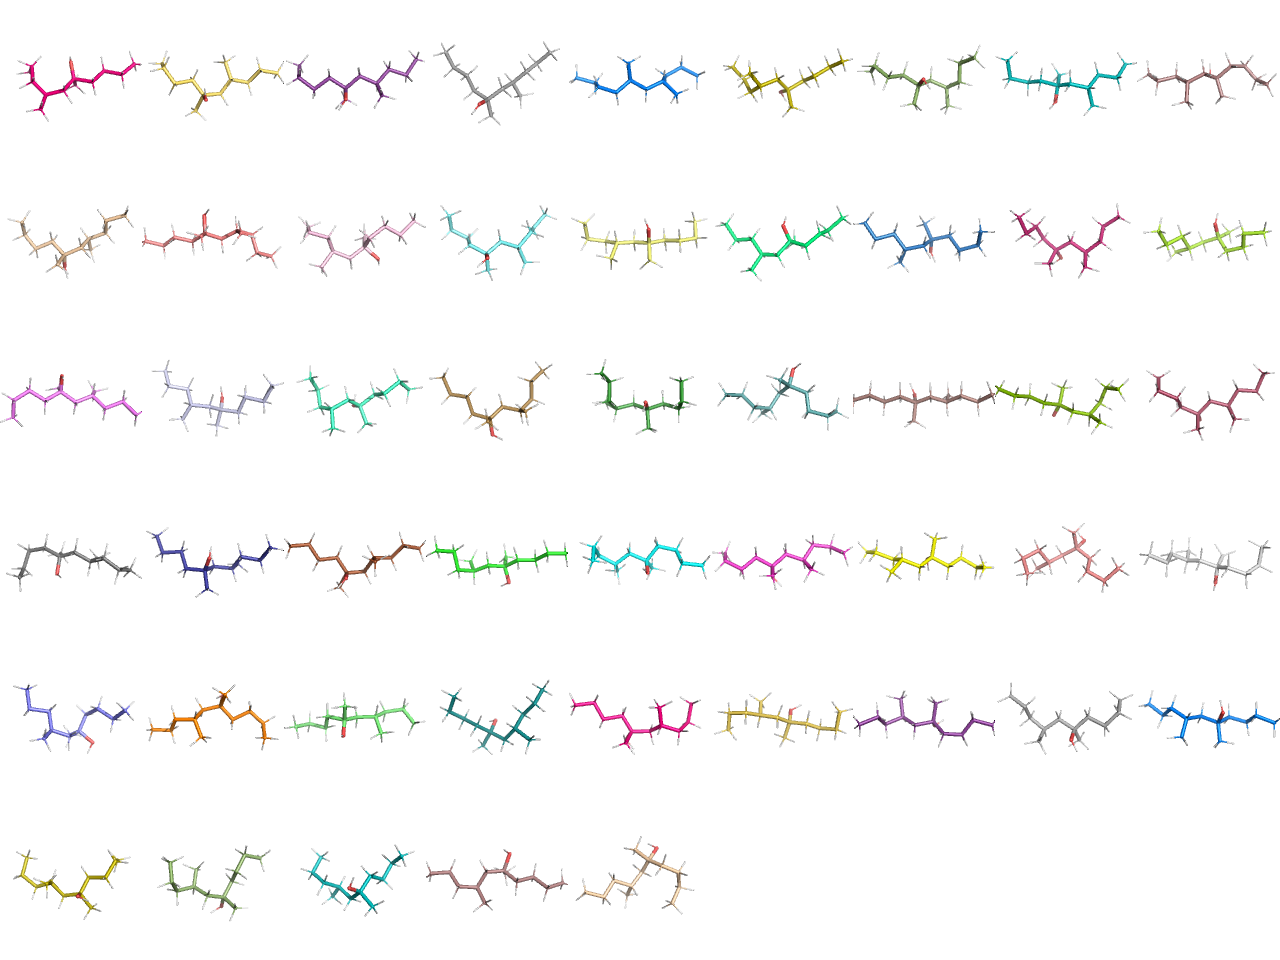

In [32]:
v.server.do('ray')
v.GetPNG()

## Generate the training data

In [33]:
coordinate_names = sum([[f'x_{n}',f'y_{n}', f'z_{n}'] for n in range(mol.GetNumAtoms())], []) # helper to define the column names

In [34]:
data = []
for conformer_id in conformer_ids:
    energy = calc_energy(mol, conformer_id)['energy_abs']
    positions = mol.GetConformer(conformer_id).GetPositions().flatten()
    position_dict = dict(zip(coordinate_names, positions))
    position_dict['energy'] = energy
                         
    data.append(position_dict)

In [35]:
data = pd.DataFrame(data).sample(len(data))

(array([1.330e+02, 8.570e+02, 1.199e+03, 6.490e+02, 2.690e+02, 7.600e+01,
        1.200e+01, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([ 36.26872091,  45.78341003,  55.29809916,  64.81278828,
         74.32747741,  83.84216653,  93.35685566, 102.87154478,
        112.38623391, 121.90092303, 131.41561216]),
 <BarContainer object of 10 artists>)

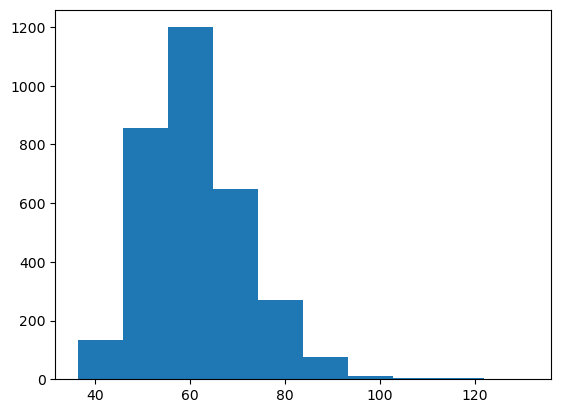

In [36]:
plt.hist(data['energy'])

## Build a model

In [37]:
positions = data[coordinate_names]
energies = data['energy']

In [ ]:
train_positions = positions[100:]
test_positions = positions[:100]
train_energies = energies[100:]
test_energies = energies[:100]

## Test the model

In [ ]:
train_predictions = model.predict(train_positions)

In [ ]:
density_scatter_with_hist(train_energies.values, train_predictions)

In [ ]:
density_scatter_with_hist(test_energies.values, test_predictions)

## Change the positions